In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
%matplotlib inline
from torch.utils.data import Dataset, DataLoader
import torch
import torchvision

import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Generate dataset

In [2]:
y = np.random.randint(0,7,2100)
idx= []
for i in range(7):
    print(i,sum(y==i))
    idx.append(y==i)

0 302
1 307
2 305
3 298
4 297
5 303
6 288


In [3]:
x1 = np.zeros((2100,2))
x = np.zeros((2100,8))

In [4]:

con_data = 0.0015*np.eye(6)  # lambda value for example  class 0 [_,_,lambda,0,0,0,0,0]



d1 = np.tile(con_data[:,0],(sum(idx[0]),1))
x1[idx[0],:] = np.random.uniform(low=[1,8],high=[2,7],size=(sum(idx[0]),2))
x[idx[0],:] = np.concatenate((x1[idx[0],:],d1),axis=1)


d2 = np.tile(con_data[:,1],(sum(idx[1]),1))
x1[idx[1],:] = np.random.uniform(low=[1,5],high=[2,6],size=(sum(idx[1]),2))
x[idx[1],:] = np.concatenate((x1[idx[1],:],d2),axis=1)

d3 = np.tile(con_data[:,2],(sum(idx[2]),1))
x1[idx[2],:] = np.random.uniform(low=[1,3],high=[2,4],size=(sum(idx[2]),2))
x[idx[2],:] = np.concatenate((x1[idx[2],:],d3),axis=1)

d4 = np.tile(con_data[:,3],(sum(idx[3]),1))
x1[idx[3],:] = np.random.uniform(low=[1,1],high=[2,2],size=(sum(idx[3]),2))
x[idx[3],:] = np.concatenate((x1[idx[3],:],d4),axis=1)


d5 = np.tile(con_data[:,4],(sum(idx[4]),1))
x1[idx[4],:] = np.random.uniform(low=[1,-1],high=[2,0],size=(sum(idx[4]),2))
x[idx[4],:] = np.concatenate((x1[idx[4],:],d5),axis=1)



d6 = np.tile(con_data[:,5],(sum(idx[5]),1))
x1[idx[5],:] = np.random.uniform(low=[1,-2],high=[2,-3],size=(sum(idx[5]),2))
x[idx[5],:] = np.concatenate((x1[idx[5],:],d6),axis=1)


d7 = np.tile(np.zeros(6),(sum(idx[6]),1))
x1[idx[6],:] = np.random.uniform(low=[2.75,0],high=[3.75,3],size=(sum(idx[6]),2))
x[idx[6],:] = np.concatenate((x1[idx[6],:],d7),axis=1)



In [5]:
x[idx[0],:][0],x[idx[1],:][0],x[idx[2],:][0],x[idx[3],:][0],x[idx[4],:][0],x[idx[5],:][0]

(array([1.52917386e+00, 7.59279203e+00, 1.50000000e-03, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00]),
 array([1.35133427e+00, 5.80329841e+00, 0.00000000e+00, 1.50000000e-03,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00]),
 array([1.25532062e+00, 3.37767807e+00, 0.00000000e+00, 0.00000000e+00,
        1.50000000e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00]),
 array([1.90068845e+00, 1.52736624e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 1.50000000e-03, 0.00000000e+00, 0.00000000e+00]),
 array([ 1.09125476, -0.49854542,  0.        ,  0.        ,  0.        ,
         0.        ,  0.0015    ,  0.        ]),
 array([ 1.78284335e+00, -2.95317814e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.50000000e-03]))

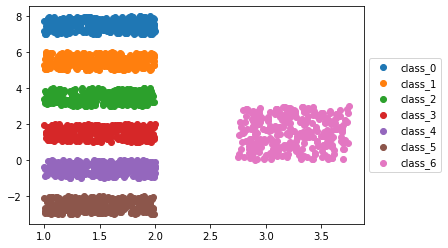

In [6]:
for i in range(7):
    plt.scatter(x[idx[i],0],x[idx[i],1],label="class_"+str(i))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig("dist_4.png",bbox_inches="tight")
plt.savefig("dist_4.pdf",bbox_inches="tight")


In [7]:
foreground_classes = {'class_0','class_1','class_2','class_3','class_4','class_5',}

background_classes = {'class_6'}

In [8]:
# creating mosaic data
desired_num = 3000
mosaic_list =[]
mosaic_label = []
fore_idx=[]
for j in range(desired_num):
    fg_class  = np.random.randint(0,6)
    fg_idx = np.random.randint(0,9) #m=9
    a = []
    for i in range(9):  #m=2
        if i == fg_idx:
            b = np.random.choice(np.where(idx[fg_class]==True)[0],size=1)
            a.append(x[b])
#             print("foreground "+str(fg_class)+" present at " + str(fg_idx))
        else:
            bg_class = np.random.randint(6,7)
            b = np.random.choice(np.where(idx[bg_class]==True)[0],size=1)
            a.append(x[b])
#             print("background "+str(bg_class)+" present at " + str(i))
    a = np.concatenate(a,axis=0)
    mosaic_list.append(np.reshape(a,(72,1)))
    mosaic_label.append(fg_class)
    fore_idx.append(fg_idx)

In [9]:
mosaic_list = np.concatenate(mosaic_list,axis=1).T
# print(mosaic_list)

In [10]:
print(np.shape(mosaic_label))
print(np.shape(fore_idx))

(3000,)
(3000,)


In [11]:
class MosaicDataset(Dataset):
  """MosaicDataset dataset."""

  def __init__(self, mosaic_list, mosaic_label, fore_idx):
    """
      Args:
        csv_file (string): Path to the csv file with annotations.
        root_dir (string): Directory with all the images.
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    self.mosaic = mosaic_list
    self.label = mosaic_label
    self.fore_idx = fore_idx

  def __len__(self):
    return len(self.label)

  def __getitem__(self, idx):
    return self.mosaic[idx] , self.label[idx], self.fore_idx[idx]

batch = 250
msd = MosaicDataset(mosaic_list, mosaic_label , fore_idx)
train_loader = DataLoader( msd,batch_size= batch ,shuffle=True)

In [12]:
class Wherenet(nn.Module):
    def __init__(self):
        super(Wherenet,self).__init__()
        self.linear1 = nn.Linear(8,1)

    def forward(self,z):
        x = torch.zeros([batch,9],dtype=torch.float64)  #m=2
        y = torch.zeros([batch,8], dtype=torch.float64)  # 8-d data
        #x,y = x.to("cuda"),y.to("cuda")
        for i in range(9):  #m=9
          x[:,i] = self.helper(z[:,8*i:8*i+8])[:,0]
            #print(k[:,0].shape,x[:,i].shape)
        x = F.softmax(x,dim=1)   # alphas
        x1 = x[:,0]
        for i in range(9): #m=9
            x1 = x[:,i]          
            #print()
            y = y+torch.mul(x1[:,None],z[:,8*i:8*i+8])
        return y , x 

    
    def helper(self,x):
        #x = F.relu(self.linear1(x))
        #x = F.relu(self.linear2(x))
        x = self.linear1(x)
        return x

    

In [13]:
# trainiter = iter(train_loader)
# input1,labels1,index1 = trainiter.next()



In [14]:
where = Wherenet().double()
# where = where
# out_where,alphas = where(input1)
# out_where.shape,alphas.shape

In [15]:
class Whatnet(nn.Module):
    def __init__(self):
        super(Whatnet,self).__init__()
        self.linear1 = nn.Linear(8,6)
        #self.linear2 = nn.Linear(4,3)
#         self.linear3 = nn.Linear(8,3)
    def forward(self,x):
        #x = F.relu(self.linear1(x))
        #x = F.relu(self.linear2(x))
        x = self.linear1(x)
        return x

In [16]:
what = Whatnet().double()
# what(out_where)

In [17]:
# creating test mosaic data
test_data_required = 1000
mosaic_list_test =[]
mosaic_label_test = []
fore_idx_test=[]
for j in range(test_data_required):
    fg_class  = np.random.randint(0,6)
    fg_idx = np.random.randint(0,9)  #m=2
    a = []
    for i in range(9): #m=2
        if i == fg_idx:
            b = np.random.choice(np.where(idx[fg_class]==True)[0],size=1)
            a.append(x[b])
#             print("foreground "+str(fg_class)+" present at " + str(fg_idx))
        else:
            bg_class = np.random.randint(6,7)
            b = np.random.choice(np.where(idx[bg_class]==True)[0],size=1)
            a.append(x[b])
#             print("background "+str(bg_class)+" present at " + str(i))
    a = np.concatenate(a,axis=0)
    mosaic_list_test.append(np.reshape(a,(72,1)))
    mosaic_label_test.append(fg_class)
    fore_idx_test.append(fg_idx)

In [18]:
mosaic_list_test = np.concatenate(mosaic_list_test,axis=1).T
print(mosaic_list_test.shape)

(1000, 72)


In [19]:
test_data = MosaicDataset(mosaic_list_test,mosaic_label_test,fore_idx_test)
test_loader = DataLoader( test_data,batch_size= batch ,shuffle=False)

In [20]:
focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0

argmax_more_than_half = 0
argmax_less_than_half =0

col1=[]
col2=[]
col3=[]
col4=[]
col5=[]
col6=[]
col7=[]
col8=[]
col9=[]
col10=[]
col11=[]
col12=[]
col13=[]

criterion = nn.CrossEntropyLoss()
optimizer_where = optim.SGD(where.parameters(), lr=0.01)#,momentum=0.9)
optimizer_what = optim.SGD(what.parameters(), lr=0.01)#, momentum=0.9)

nos_epochs = 500   # no of epochs

train_loss=[]
test_loss =[]
train_acc = []
test_acc = []
for epoch in range(nos_epochs):  # loop over the dataset multiple times

    focus_true_pred_true =0
    focus_false_pred_true =0
    focus_true_pred_false =0
    focus_false_pred_false =0

    argmax_more_than_half = 0
    argmax_less_than_half =0

    running_loss = 0.0
    cnt=0

    iteration = desired_num // batch

    #training data set

    for i, data in  enumerate(train_loader):
        inputs , labels , fore_idx = data
        #inputs,labels,fore_idx = inputs.to(device),labels.to(device),fore_idx.to(device)
        # zero the parameter gradients

        optimizer_what.zero_grad()
        optimizer_where.zero_grad()
        
        
        avg_inp,alphas = where(inputs)
        
        outputs = what(avg_inp)
        
        _, predicted = torch.max(outputs.data, 1)
        
        loss = criterion(outputs, labels) 
        loss.backward() 
        
        optimizer_what.step()
        optimizer_where.step() 
        

        running_loss += loss.item()
        #if  ((1.0*running_loss)/6) <0.01:
         # break
        if cnt % 6 == 5:    # print every 6 mini-batches
            print('[%d, %5d] loss: %.3f' %(epoch + 1, cnt + 1, running_loss / 6))
            running_loss = 0.0

        cnt=cnt+1
    
        if epoch % 5 == 4:
            for j in range (batch):
                focus = torch.argmax(alphas[j])

                if(alphas[j][focus] >= 0.5):
                    argmax_more_than_half +=1
                else:
                    argmax_less_than_half +=1

                if(focus == fore_idx[j] and predicted[j] == labels[j]):
                    focus_true_pred_true += 1

                elif(focus != fore_idx[j] and predicted[j] == labels[j]):
                    focus_false_pred_true +=1

                elif(focus == fore_idx[j] and predicted[j] != labels[j]):
                    focus_true_pred_false +=1

                elif(focus != fore_idx[j] and predicted[j] != labels[j]):
                    focus_false_pred_false +=1

    if epoch % 5 == 4:
        col1.append(epoch)
        col2.append(argmax_more_than_half)
        col3.append(argmax_less_than_half)
        col4.append(focus_true_pred_true)
        col5.append(focus_false_pred_true)
        col6.append(focus_true_pred_false)
        col7.append(focus_false_pred_false)

    #************************************************************************
        #testing data set  
        with torch.no_grad():
            focus_true_pred_true =0
            focus_false_pred_true =0
            focus_true_pred_false =0
            focus_false_pred_false =0

            argmax_more_than_half = 0
            argmax_less_than_half =0
            for data in test_loader:
                inputs, labels , fore_idx = data
                #inputs,labels,fore_idx = inputs.to(device),labels.to(device),fore_idx.to(device) 
#                 print(inputs.shtorch.save(where.state_dict(),"model_epoch"+str(epoch)+".pt")ape,labels.shape)
                avg_inp,alphas = where(inputs)
                outputs = what(avg_inp)
                _, predicted = torch.max(outputs.data, 1)

                for j in range (batch):
                    focus = torch.argmax(alphas[j])

                    if(alphas[j][focus] >= 0.5):
                        argmax_more_than_half +=1
                    else:
                        argmax_less_than_half +=1

                    if(focus == fore_idx[j] and predicted[j] == labels[j]):
                        focus_true_pred_true += 1

                    elif(focus != fore_idx[j] and predicted[j] == labels[j]):
                        focus_false_pred_true +=1

                    elif(focus == fore_idx[j] and predicted[j] != labels[j]):
                        focus_true_pred_false +=1

                    elif(focus != fore_idx[j] and predicted[j] != labels[j]):
                        focus_false_pred_false +=1

        col8.append(argmax_more_than_half)
        col9.append(argmax_less_than_half)
        col10.append(focus_true_pred_true)
        col11.append(focus_false_pred_true)
        col12.append(focus_true_pred_false)
        col13.append(focus_false_pred_false)
        
        #torch.save(where.state_dict(),"where_model_epoch"+str(epoch)+".pt")
        #torch.save(what.state_dict(),"what_model_epoch"+str(epoch)+".pt")
    
print('Finished Training')
#torch.save(where.state_dict(),"where_model_epoch"+str(nos_epochs)+".pt")
#torch.save(what.state_dict(),"what_model_epoch"+str(epoch)+".pt")


[1,     6] loss: 1.955
[1,    12] loss: 1.902
[2,     6] loss: 1.889
[2,    12] loss: 1.858
[3,     6] loss: 1.851
[3,    12] loss: 1.831
[4,     6] loss: 1.821
[4,    12] loss: 1.815
[5,     6] loss: 1.806
[5,    12] loss: 1.796
[6,     6] loss: 1.790
[6,    12] loss: 1.782
[7,     6] loss: 1.777
[7,    12] loss: 1.768
[8,     6] loss: 1.764
[8,    12] loss: 1.757
[9,     6] loss: 1.754
[9,    12] loss: 1.741
[10,     6] loss: 1.736
[10,    12] loss: 1.731
[11,     6] loss: 1.723
[11,    12] loss: 1.715
[12,     6] loss: 1.710
[12,    12] loss: 1.696
[13,     6] loss: 1.691
[13,    12] loss: 1.679
[14,     6] loss: 1.676
[14,    12] loss: 1.655
[15,     6] loss: 1.643
[15,    12] loss: 1.643
[16,     6] loss: 1.631
[16,    12] loss: 1.607
[17,     6] loss: 1.593
[17,    12] loss: 1.595
[18,     6] loss: 1.581
[18,    12] loss: 1.556
[19,     6] loss: 1.550
[19,    12] loss: 1.537
[20,     6] loss: 1.524
[20,    12] loss: 1.516
[21,     6] loss: 1.498
[21,    12] loss: 1.497
[22,     6

In [21]:
columns = ["epochs", "argmax > 0.5" ,"argmax < 0.5", "focus_true_pred_true", "focus_false_pred_true", "focus_true_pred_false", "focus_false_pred_false" ]
df_train = pd.DataFrame()
df_test = pd.DataFrame()
df_train[columns[0]] = col1
df_train[columns[1]] = col2
df_train[columns[2]] = col3
df_train[columns[3]] = col4
df_train[columns[4]] = col5
df_train[columns[5]] = col6
df_train[columns[6]] = col7

df_test[columns[0]] = col1
df_test[columns[1]] = col8
df_test[columns[2]] = col9
df_test[columns[3]] = col10
df_test[columns[4]] = col11
df_test[columns[5]] = col12
df_test[columns[6]] = col13

In [22]:
df_train

,epochs,argmax > 0.5,argmax < 0.5,focus_true_pred_true,focus_false_pred_true,focus_true_pred_false,focus_false_pred_false
0,4,0,3000,14,0,1700,1286
1,9,0,3000,113,6,1600,1281
2,14,409,2591,5,292,1671,1032
3,19,838,2162,549,442,1102,907
4,24,1027,1973,743,490,885,882
...,...,...,...,...,...,...,...
95,479,2212,788,2471,17,505,7
96,484,2276,724,2502,9,484,5
97,489,2355,645,2509,5,483,3
98,494,2422,578,2511,2,485,2


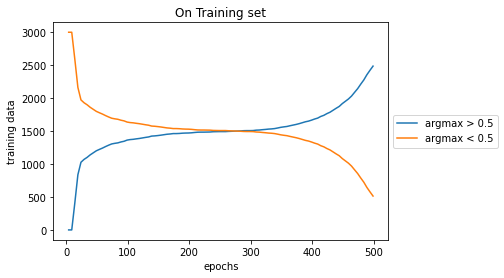

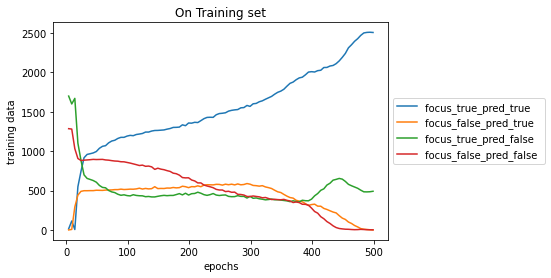

In [23]:
plt.plot(col1,col2, label='argmax > 0.5')
plt.plot(col1,col3, label='argmax < 0.5')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("training data")
plt.title("On Training set")
plt.show()

plt.plot(col1,col4, label ="focus_true_pred_true ")
plt.plot(col1,col5, label ="focus_false_pred_true ")
plt.plot(col1,col6, label ="focus_true_pred_false ")
plt.plot(col1,col7, label ="focus_false_pred_false ")
plt.title("On Training set")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("training data")
plt.savefig("dist_4_train.png",bbox_inches="tight")
plt.savefig("dist_4_train.pdf",bbox_inches="tight")
plt.show()

In [24]:
df_test

,epochs,argmax > 0.5,argmax < 0.5,focus_true_pred_true,focus_false_pred_true,focus_true_pred_false,focus_false_pred_false
0,4,0,1000,5,0,568,427
1,9,0,1000,23,8,548,421
2,14,156,844,0,114,562,324
3,19,289,711,176,152,380,292
4,24,344,656,251,162,299,288
...,...,...,...,...,...,...,...
95,479,743,257,829,6,164,1
96,484,763,237,825,4,170,1
97,489,793,207,827,0,172,1
98,494,820,180,825,0,175,0


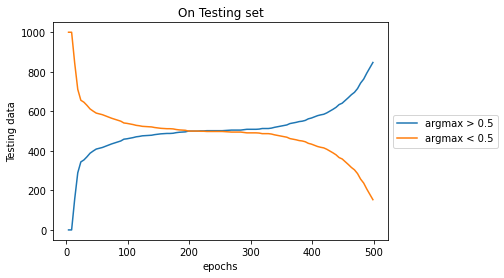

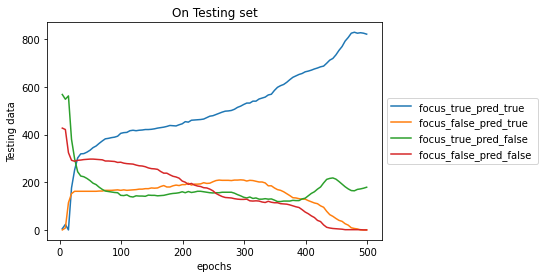

In [25]:
plt.plot(col1,col8, label='argmax > 0.5')
plt.plot(col1,col9, label='argmax < 0.5')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("Testing data")
plt.title("On Testing set")
plt.show()

plt.plot(col1,col10, label ="focus_true_pred_true ")
plt.plot(col1,col11, label ="focus_false_pred_true ")
plt.plot(col1,col12, label ="focus_true_pred_false ")
plt.plot(col1,col13, label ="focus_false_pred_false ")
plt.title("On Testing set")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("Testing data")
plt.savefig("dist_4_test.png",bbox_inches="tight")
plt.savefig("dist_4_test.pdf",bbox_inches="tight")
plt.show()

In [26]:
# avrg = []
# lbl = []
# with torch.no_grad():
#   for i, data in  enumerate(train_loader):
#           inputs , labels , fore_idx = data
#           avg_inp,alphas = where(inputs)
#           avrg.append(avg_inp)
#           lbl.append(labels.numpy())
# avrg= np.concatenate(avrg,axis=0)
# lbl = np.concatenate(lbl,axis=0)

In [27]:
# indices = []
# for i in range(6):
#     print(i,sum(lbl==i))
#     indices.append(lbl==i)

In [28]:
# avrg[indices[4],:][0]

In [29]:
true = []
pred = []
acc= 0
for i, data in  enumerate(train_loader):
        inputs , labels , fore_idx = data
        avg_inp,alphas = where(inputs)
        outputs = what(avg_inp)
        _, predicted = torch.max(outputs.data, 1)
        true.append(labels)
        pred.append(predicted)
        acc+=sum(predicted == labels)

In [30]:
true = np.concatenate(true,axis=0)
pred = np.concatenate(pred,axis=0)

In [31]:
from sklearn.metrics import confusion_matrix
confusion_matrix(true,pred)

array([[488,  40,   0,   0,   0,   0],
       [166, 309,  31,   0,   0,   0],
       [  0,  85, 404,  10,   0,   0],
       [  0,   0,  44, 453,   1,   0],
       [  0,   0,   0,   5, 421,  72],
       [  0,   0,   0,   2,  29, 440]])

In [32]:
sum(true==pred)

2515

In [33]:
a = [1,2,3]
b = [4,5,6]

In [34]:
list(np.append(a,b))

[1, 2, 3, 4, 5, 6]

In [35]:
a

[1, 2, 3]